# Adversarial Variational Optimization: PYTHIA Tuning

In this notebook Adversarial Variational Optimization (https://arxiv.org/abs/1707.07113) is applied to tuning parameters of a simplistic detector.

**Note: this notebook takes quite a long time to execute. It is recommended to run all cells at the beginning.**

**Please, don't interrupt the notebook while sampling from PythiaMill. Otherwise it might stuck at the next attempt to sample from it. IF this happens, please, restart the notebook.**

In [1]:
### installation might take a few minutes
def install_pip(url):
    import subprocess as sp
    result = sp.run(
        ['pip', 'install', 'git+%s' % (url, )],
        stdout=sp.PIPE, stderr=sp.PIPE
    )
    
    if result.returncode != 0:
        print(result.stdout.decode('utf-8'))
        print(result.stderr.decode('utf-8'))

try:
    import mlhep2019
    import pythiamill as pm
except ModuleNotFoundError:
    install_pip('https://github.com/yandexdataschool/mlhep2019.git')
    install_pip('https://gitlab.com/mborisyak/ensure-pythia.git')
    install_pip('https://gitlab.com/mborisyak/pythia-mill.git')
    import mlhep2019
    import pythiamill as pm

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import numpy as np
import torch

import torch.nn.functional as F

In [3]:
for i in range(torch.cuda.device_count()):
  print(torch.cuda.get_device_name(i))
  
if torch.cuda.is_available():
  device = torch.device("cuda:%d" % (torch.cuda.device_count() - 1, ))
else:
  device = "cpu"
  print('Using CPU')

Tesla K80
Tesla K80
Tesla K80
Tesla K80


## Generators

Pythia-mill is a python binding to Pythia generator that can run in multiple threads (processes).
For more details, please, visit https://github.com/maxim-borisyak/pythia-mill

### Note about the change of problem

The reason the detector parameters (instead of Pythia parameters) are the target for the tune is a purely technical one: on each step AVO requires samples from multiples configurations of generator + detector. However, Pythia requires about half of a second to be reconfigured, which induces a tremendous overhead.

By contrast, this simplistic detector is designed to accept its parameters as function arguments (effectively neglecting any overhead).


The detector emulates a $32 \times 32$ spherical uniform grid in `pseudorapidity` ($\eta$)-`angle in traverse plane` ($\phi$) covering $(\eta, \phi) \in [0, 5] \times [0, 2 \pi]$.

The detector is parametrized by offset in $z$-axis relative to the beam crossing point. Zero offset means that center of the sphere coincides with the collision point.

In [4]:
### ground truth offset, unknown in the real world problems.
TRUE_OFFSET=1
SEED=111888

In [5]:
options = pm.config.please_be_quiet + [
    ### setting default parameters to Monash values
    ### all options are taken from https://arxiv.org/abs/1610.08328
    "Tune:ee = 7",
    "Beams:idA = 11",
    "Beams:idB = -11",
    "Beams:eCM = 91.2",
    "WeakSingleBoson:ffbar2gmZ = on",
    "23:onMode = off",
    "23:onIfMatch = 1 -1",
    "23:onIfMatch = 2 -2",
    "23:onIfMatch = 3 -3",
    "23:onIfMatch = 4 -4",
    "23:onIfMatch = 5 -5",
]

In [6]:
### defining the detector
detector = pm.utils.SphericalTracker(
    ### with this option detector measures total energy
    ### of the particles traversing each pixel.
    is_binary=False,
    
    ### detector covers [0, 5] pseudo-rapidity range
    max_pseudorapidity=5.0,
    pseudorapidity_steps=32, phi_steps=32,
    ### 1 layer with radius 10 mm.
    n_layers=1, R_min=10.0, R_max=10.0,
)
    
mill = pm.ParametrizedPythiaMill(
    detector, options,
    batch_size=8,
    n_workers=1,
    seed=SEED
)

In [7]:
def get_data(mill, detector_configurations, progress=None):
    """
    Utilitary function to obtain data for a particular set of configurations.
    
    :param mill: instance of Pythia Mill to sample from.
    : param detector configuration: - list of configurations.
        each configuration should be an array of detector parameters.
    : param progress: set to tqdm-like object to display progress.  
    
    :return:
        - parameters: array of shape `<number of samples> x <parameters dim>`, parameters for each sample;
        - samples: array of shape `<number of samples> x 1 x 32 x 32`, sampled events.
    """
    if progress is None:
      progress = lambda x: x
    
    try:
        ### sending requests to the queue
        for args in detector_configurations:
            mill.request(*args)

        ### retrieving results
        data = [
            mill.retrieve()
            for _ in progress(range(len(detector_configurations)))
        ]

        samples = np.vstack([ samples for params, samples in data ])
        params = np.vstack([
            np.array([params] * samples.shape[0], dtype='float32')
            for params, samples in data
        ])

        return params, samples.reshape(-1, 1, 32, 32)
    finally:
        while mill.pending_requests() > 0:
            mill.retrieve()

In [8]:
### Generating training samples with ground truth parameters.
### For a real-world problem these arrays would correspond to real data.
_, data_true_train = get_data(mill, detector_configurations=[(TRUE_OFFSET, )] * 2 ** 12, progress=tqdm)
_, data_true_val = get_data(mill, detector_configurations=[(TRUE_OFFSET, )] * 2 ** 12, progress=tqdm)

In [9]:
X_true_train = torch.tensor(data_true_train, dtype=torch.float32, device=device)
X_true_val = torch.tensor(data_true_val, dtype=torch.float32, device=device)

In [10]:
print(data_true_train.shape)
print(data_true_val.shape)

(32768, 1, 32, 32)
(32768, 1, 32, 32)


### Taking a look at events

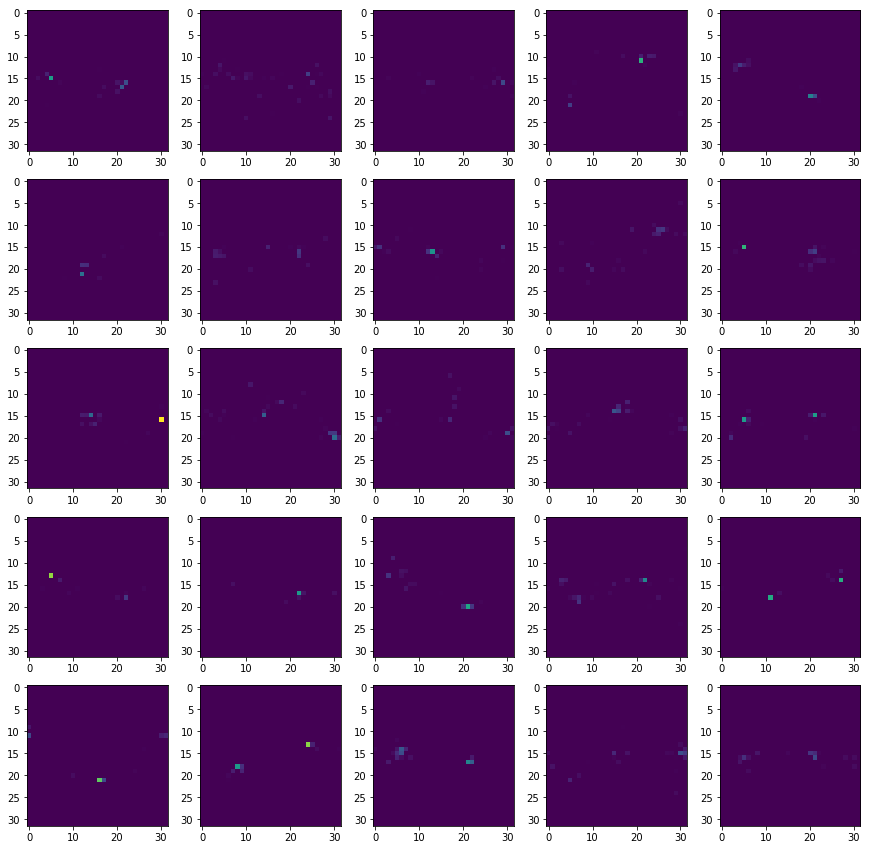

In [11]:
n = 5
plt.subplots(nrows=n, ncols=n, figsize=(3 * n, 3 * n))

max_energy = np.max(data_true_train[:n * n])

for i in range(n):
    for j in range(n):
        k = i * n + j
        plt.subplot(n, n, k + 1)
        plt.imshow(data_true_train[k, 0, :, :], vmin=0, vmax=max_energy)

plt.show()

### Aggregated events

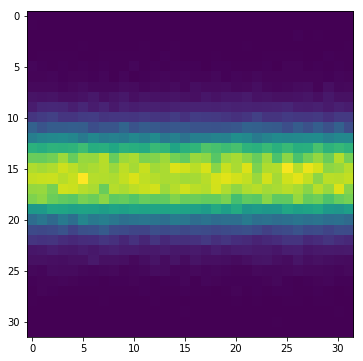

In [12]:
plt.figure(figsize=(6, 6))
plt.imshow(np.sum(data_true_train, axis=(0, 1)), vmin=0)
plt.show()

## Discriminator

### Building conv net

In [13]:
class Discriminator(torch.nn.Module):
    def __init__(self, n=8):
        super(Discriminator, self).__init__()

        self.layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1    , 2 * n, (3, 3)), torch.nn.LeakyReLU(),
            torch.nn.Conv2d(2 * n, 2 * n, (3, 3)), torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 2)),
            
            torch.nn.Conv2d(2 * n, 3 * n, (3, 3)), torch.nn.LeakyReLU(),
            torch.nn.Conv2d(3 * n, 3 * n, (3, 3)), torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 2)),
            
            torch.nn.Conv2d(3 * n, 4 * n, (3, 3)), torch.nn.LeakyReLU(),
            torch.nn.Conv2d(4 * n, 4 * n, (3, 3)), torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d((2, 2)),
        ])
        
        self.head = torch.nn.Linear(4 * n, 1)
        
    def forward(self, X):
        result = X

        for l in self.layers:
            result = l(result)

        result = torch.squeeze(
          torch.squeeze(result, dim=3), dim=2
        )
        result = self.head(result)

        return torch.squeeze(result, dim=1)

In [14]:
discriminator = Discriminator(n=8).to(device)

In [15]:
assert discriminator(torch.rand((7, 1, 32, 32), dtype=torch.float32, device=device)).shape[0] == 7

In Adversarial Variational Optimization, instead of searching for a single value of detector parameters, a parametrized distribution is introduced (with parameters $\psi$):

$$\mathcal{L}(\psi) = \mathrm{JS}(X_\psi, X_\mathrm{data})$$
where:
- $X_\psi \sim \mathrm{detector}(\theta), \theta \sim P_\psi$;
- $X_\mathrm{data} \sim \mathrm{reality}$.

Note that $\mathcal{L}(\psi)$ is a vaiational bound on adversarial loss:

$$\mathcal{L}(\psi) \geq \min_\theta \mathcal{L}_\mathrm{adv}(\theta) = \mathrm{JS}(X_\theta, X_\mathrm{data})$$

In this example, detector parameters consist of a signle `offset` parameter. For simplicity normal distibution is used:

$$\mathrm{offset} \sim \mathcal{N}(\mu, \sigma)$$


In order to avoid introducing constraints $\sigma \geq 0$, an auxiliary *free variable* $\sigma'$ is introduced (denoted as `detector_params_sigma_raw` in the code):
$$\sigma = \log(1 + \exp(\sigma'))$$

Note that if there exists configuration of detector perfectly matching real data, then minimum of variational bound is achieved when the `offset` distribution collapses into delta function with the center at minumum of adversarial loss.
Otherwise, a mixture of detector configuations might be a solution (unlike convetional variational optimization).

In [16]:
detector_offset_mean = torch.nn.Parameter(
    torch.tensor(
      data=0.0, dtype=torch.float32, device=device, requires_grad=True
    )
)

detector_offset_sigma_raw = torch.nn.Parameter(
    torch.tensor(
      data=0.0, dtype=torch.float32, device=device, requires_grad=True
    )
)

def detector_neg_log_prob(params):
  sigma = torch.nn.functional.softplus(detector_offset_sigma_raw)
  
  return torch.log(sigma) + 0.5 * (
      (params - detector_offset_mean) ** 2 / (sigma ** 2)
  )

def variational_bound(fs, params):
  return torch.mean(
      fs * detector_neg_log_prob(params)
  )

In [17]:
def loss_fn_discr(predictions_true, predictions_gen):
    return 0.5 * torch.mean(F.softplus(-predictions_true)) + 0.5 * torch.mean(F.softplus(predictions_gen))

In [18]:
opt_gen = torch.optim.Adam([detector_offset_mean, detector_offset_sigma_raw], lr=1e-2, betas=(0.9, 0.99))
opt_discr = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

In [19]:
def discriminator_step():
    mean = detector_offset_mean.cpu().detach().numpy()
    std = torch.nn.functional.softplus(detector_offset_sigma_raw).cpu().detach().numpy()
    
    offset = np.random.normal() * std + mean
    
    mill.request(offset)
    _, data_gen = mill.retrieve()
    
    X_gen_batch = torch.tensor(data_gen.reshape((-1, 1, 32, 32)), dtype=torch.float32, device=device)
    X_true_batch = X_true_train[torch.randint(0, X_true_train.shape[0], size=(8, ))]
    
    opt_discr.zero_grad()
    loss = loss_fn_discr(discriminator(X_true_batch), discriminator(X_gen_batch))

    loss.backward()
    opt_discr.step()

In [20]:
def generator_step():
    mean = detector_offset_mean.cpu().detach().numpy()
    std = torch.nn.functional.softplus(detector_offset_sigma_raw).cpu().detach().numpy()
    
    offset = np.random.normal() * std + mean
    
    mill.request(offset)
    params, data_gen = mill.retrieve()
    
    X_gen_batch = torch.tensor(data_gen.reshape((-1, 1, 32, 32)), dtype=torch.float32, device=device)
    
    params_train = torch.tensor(
        params,
        dtype=torch.float32, device=device
    )
    
    opt_gen.zero_grad()
    
    predictions = discriminator(X_gen_batch)
    loss = variational_bound(predictions, params_train)
    
    loss.backward()
    opt_gen.step()

AVO makes small changes in parameter distribution. When starting with the optimal discriminator from the previous iterations, adjusting discriminator to these changes should require relatively few optimization steps.

However, the initial discriminator state (which is just random weights), most probably, does not correspond to any optimal discriminator. Therefore, we pretrain discriminator in order to ensure that only a few epoches needed on each iteration to achieve an optimal discriminator.

In [21]:
for _ in tqdm(range(4096), desc='pretraining'):
    discriminator_step()

## Variational optimization

In [22]:
def show(means, stds, iteration=None):
    if iteration is None:
        i = means.shape[0] - 1
    else:
        i = iteration
    
    plt.figure(figsize=(18, 9))
    plt.plot(means[:i + 1], color='blue', label='mean ($\\mu$)')

    plt.fill_between(
        np.arange(i + 1),
        means[:i + 1] - stds[:i + 1],
        means[:i + 1] + stds[:i + 1],
        color='blue',
        label='sigma ($\\sigma$)',
        alpha=0.2
    )

    plt.plot([0, n_iterations - 1], [TRUE_OFFSET, TRUE_OFFSET], '--', color='black', alpha=0.5, label='ground truth')
    plt.ylim([-2, 4])
    plt.legend(loc='upper left', fontsize=18)
    plt.legend(fontsize=18)
    plt.xlabel('AVO step', fontsize=16)
    plt.ylabel('detector offset', fontsize=16)
    plt.show()

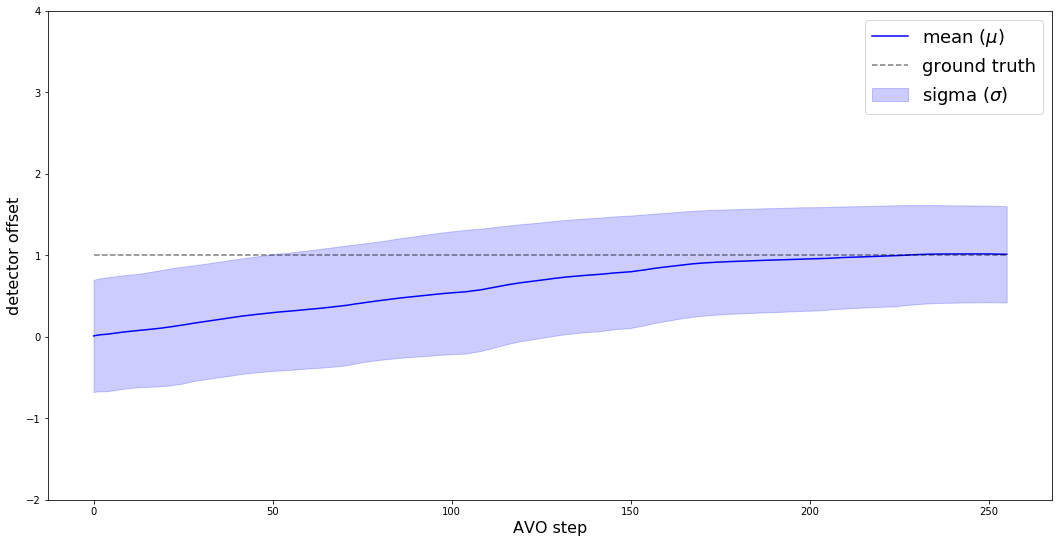

In [23]:
from IPython import display

n_iterations = 256

generator_mean_history = np.ndarray(shape=(n_iterations, ))
generator_sigma_history = np.ndarray(shape=(n_iterations, ))

for i in range(n_iterations):
    for _ in range(64):
        discriminator_step()
        
    generator_step()
    
    generator_mean_history[i] = detector_offset_mean.cpu().detach().numpy()
    generator_sigma_history[i] = torch.nn.functional.softplus(detector_offset_sigma_raw).cpu().detach().numpy()
    
    display.clear_output(wait=True)
    show(generator_mean_history, generator_sigma_history, iteration=i)

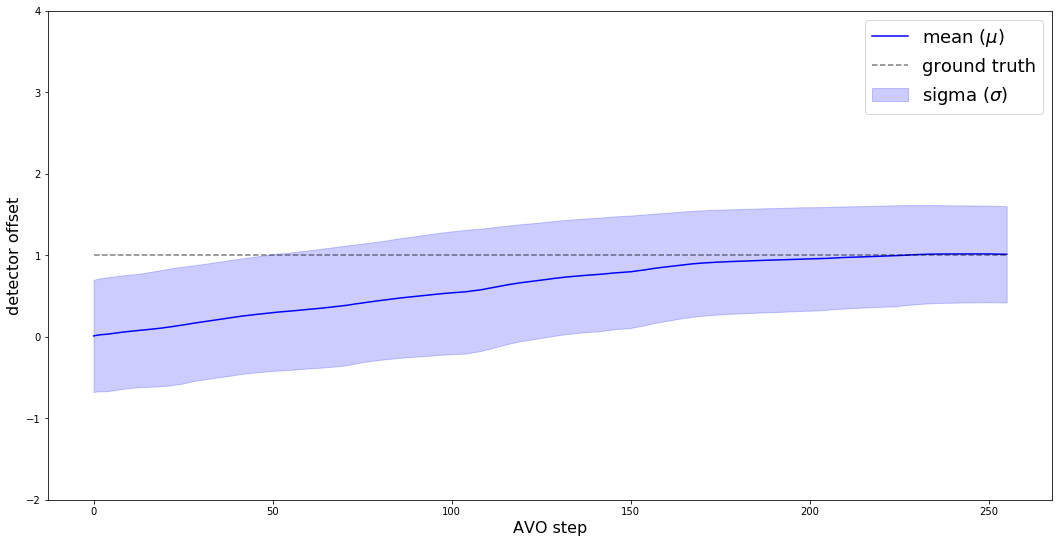

In [24]:
show(generator_mean_history, generator_sigma_history)

## Your turn

This notebook implements a minimal examples of AVO. Consult the original paper (https://arxiv.org/abs/1707.07113) to find about various tricks that can be used for improvement:
- implement entropy penalty;
- implement R1 regularization for the discriminator.